## Libraries import

In [12]:
library(data.table)
library(corrplot)
library(ggplot2)
library(ggalt)
library(ggExtra)
library(ggthemes)
library(gridExtra)

## Dataset

In [13]:
happiness_indicators <- fread("datasets/happiness_indicators.csv", 
                              header = TRUE, sep = ",", drop = 1)
head(happiness_indicators,10)

country,wb.countrycode,pop.2015,happiness.score,hdi.2015,years.schooling,suicide.per100k,homicide.per100k,prison.pop.100k,consumption.percapita
Afghanistan,AFG,33736494,3.575,0.479,3.5,4.8,7.4,88,0.02
Angola,AGO,27859305,4.033,0.533,5.0,5.0,10.1,93,5.65
Albania,ALB,2880703,4.959,0.764,9.6,6.0,4.2,193,4.77
United Arab Emirates,ARE,9154302,6.901,0.840,9.5,2.8,3.9,104,2.03
Argentina,ARG,43417765,6.574,0.827,9.8,8.8,6.3,186,8.42
Armenia,ARM,2916950,4.350,0.743,11.3,7.0,2.5,131,3.84
Australia,AUS,23850784,7.284,0.939,13.2,13.8,1.1,167,9.52
Austria,AUT,8642699,7.200,0.893,11.3,16.0,0.6,98,11.40
Azerbaijan,AZE,9649341,5.212,0.759,11.2,2.7,2.4,235,0.84
Belgium,BEL,11274196,6.937,0.896,11.4,20.1,1.0,91,10.36


## Correlogram

I first compiled a data set based on indicators that are possibly related to happiness. Then looked at correlation scores between variables.

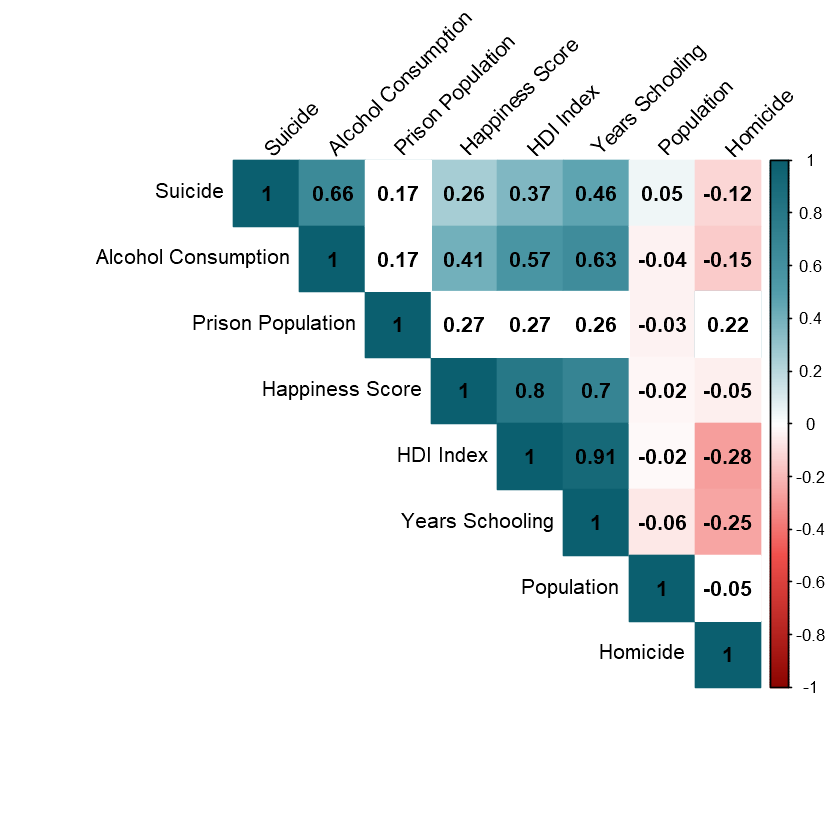

In [14]:
# Save as png
# png("correlogram.png", width = 8, height = 8, units = 'in', res = 800)

# Subseting data to columns with numerical values
corr_matrix <-cor(subset(happiness_indicators, select=pop.2015:consumption.percapita))

# Renaming columns and rows
colnames(corr_matrix) <- c("Population", "Happiness Score", "HDI Index", "Years Schooling", 
                           "Suicide", "Homicide", "Prison Population", "Alcohol Consumption")
rownames(corr_matrix) <- c("Population", "Happiness Score", "HDI Index", "Years Schooling",
                           "Suicide", "Homicide", "Prison Population", "Alcohol Consumption")

# Computing the p-value of correlations
cor.mtest <- function(mat, ...) {
    mat <- as.matrix(mat)
    n <- ncol(mat)
    p.mat<- matrix(NA, n, n)
    diag(p.mat) <- 0
    for (i in 1:(n - 1)) {
        for (j in (i + 1):n) {
            tmp <- cor.test(mat[, i], mat[, j], ...)
            p.mat[i, j] <- p.mat[j, i] <- tmp$p.value
        }
    }
  colnames(p.mat) <- rownames(p.mat) <- colnames(mat)
  p.mat
}

# Matrix of the p-value of the correlation
p.mat <- cor.mtest(corr_matrix)

# Setting color palette
col <- colorRampPalette(c("#8D0400", "#F0504C", "#FFFFFF", "#539EAC", "#0B5F6F"))

# Creating plot
corrplot(corr_matrix, method="color", col=col(200),  
         type="upper", order="hclust", 
         addCoef.col = "black",
         tl.col="black", tl.srt=45,
         p.mat = p.mat, sig.level = 0.6, insig = "blank", 
         diag=T
         ) 

# dev.off()

## Suicides vs Happiness Score

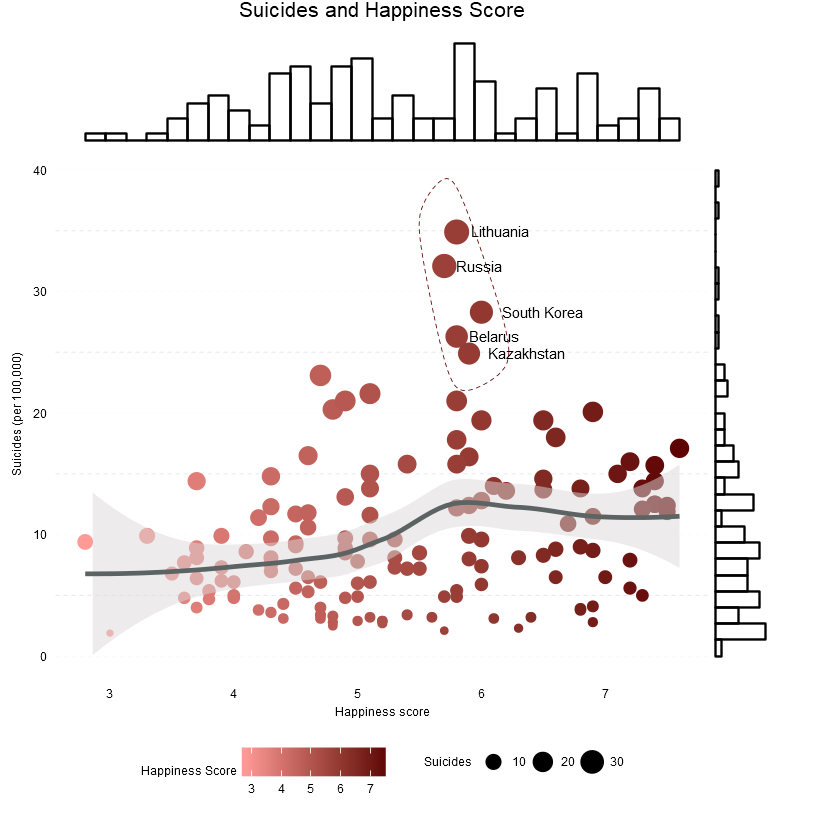

In [15]:
# Save as png
# png("happiness_score.png", width = 8, height = 6, units = 'in', res = 800)

# Round Happiness score
happiness_indicators$happiness.score.rounded <- round(happiness_indicators$happiness.score,1)

# Extract subset of data to use for encircle
high_suicide_happiness <- happiness_indicators[happiness_indicators$happiness.score > 5.5 & 
                            happiness_indicators$suicide.per100k > 25, ]

# Scatterplot
happiness_score <- ggplot(happiness_indicators, aes(x=happiness.score.rounded, y=suicide.per100k)) +
    geom_point(aes(col=happiness.score.rounded, size=suicide.per100k)) +
    geom_smooth(method="loess", se=T, color="#5c6363", fill="#dcd8d8", alpha=0.5) +
    
    # xlim(c(2.5, 8)) + 
    ylim(c(0, 40)) +

    geom_encircle(aes(x=happiness.score.rounded, y=suicide.per100k),
                  data=high_suicide_happiness,
                  color="#5D0200",
                  size=0.5,
                  expand=0.09,
                  linetype='dashed') +

    geom_text(aes(label=ifelse(happiness_indicators$happiness.score > 5 & 
                            happiness_indicators$suicide.per100k > 23, 
                               as.character(happiness_indicators$country),'')), 
              hjust=-.25, vjust=.5, size = 3) +

    labs(title="Suicides and Happiness Score",
         y="Suicides (per 100,000)",
         x="Happiness score",
         caption="",
         legend="",
         color = "Happiness Score",
         size = "Suicides") +

    scale_color_gradient(low = "#FF9A97", high = "#5D0200") +
    theme_minimal() +
    theme(
        plot.title = element_text(size=12,
                                  color="black",
                                  face="plain",
                                  vjust= 0.5,
                                  hjust = 0.5), 
        plot.subtitle  = element_text(size=12,
                                  color="black", 
                                  vjust= 0.5,
                                  hjust = 0.5),
        plot.caption = element_text(hjust=0.5, size=rel(1.2)),
        
        panel.grid.minor.x=element_blank(),
        panel.grid.major.x=element_blank(),
        
        axis.title = element_text(size=7,
                                  color="black",
                                  face="plain",
                                  vjust= 0.5,
                                  hjust = 0.5),
        axis.text = element_text(size=7,
                                  color="black"),
        line = element_line(size=.05,
                            linetype='dashed'),
        legend.title = element_text(size=7,
                                  color="black",
                                  face="plain"),
        legend.text = element_text(size=7,
                                  color="black", 
                                  face="plain"),
        legend.position="bottom"
       )

ggMarginal(happiness_score, type = "histogram", fill="transparent")

# dev.off()

## Suicides vs Human Development Index (HDI)

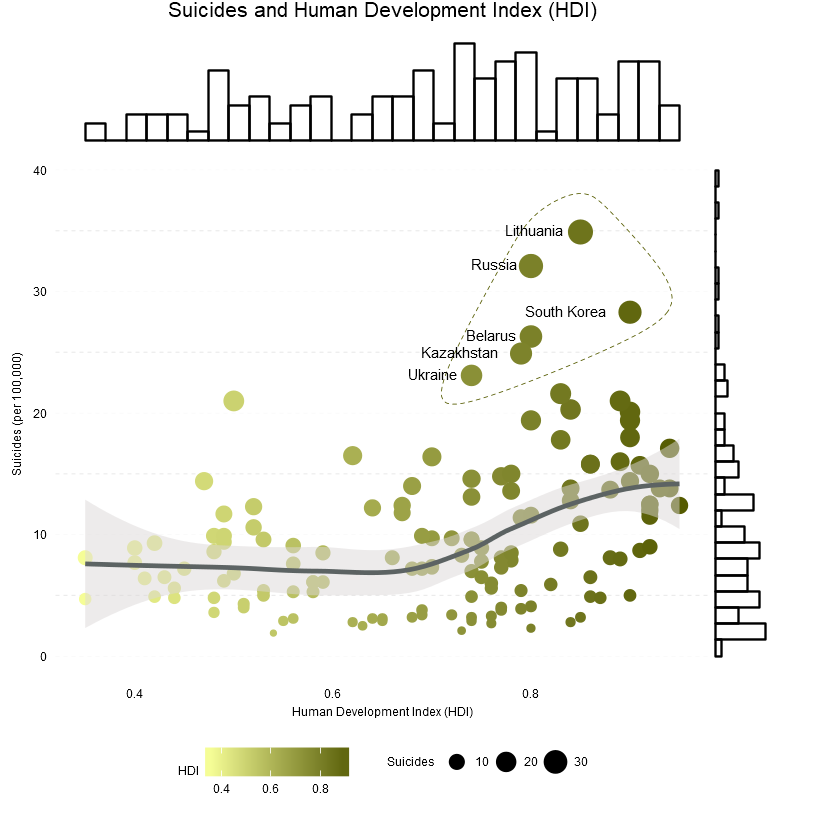

In [16]:
# Save as png
# png("hdi.png", width = 8, height = 6, units = 'in', res = 800)

# Round HDI score
happiness_indicators$hdi.2015.rounded <- round(happiness_indicators$hdi.2015,2)

# Extract subset of data to use for encircle
high_suicide_hdi <- happiness_indicators[happiness_indicators$hdi.2015 > .74 & 
                            happiness_indicators$suicide.per100k > 22, ]

# Scatterplot
hdi_plot <- ggplot(happiness_indicators, aes(x=hdi.2015.rounded, y=suicide.per100k)) + 
    geom_point(aes(col=hdi.2015.rounded, size=suicide.per100k)) +
    geom_smooth(method="loess", se=T, color="#5c6363", fill="#dcd8d8", alpha=0.5) +
 
    # xlim(c(2.5, 8)) + 
    ylim(c(0, 40)) +

    geom_encircle(aes(x=hdi.2015.rounded, y=suicide.per100k),
                  data=high_suicide_hdi,
                  color="#555B00",
                  size=0.5,
                  expand=0.07,
                  linetype='dashed') +

    geom_text(aes(label=ifelse(happiness_indicators$hdi.2015 > .74 & 
                            happiness_indicators$suicide.per100k > 22, 
                               as.character(happiness_indicators$country),'')), 
              hjust=1.3, vjust=.4, size = 3) +

    labs(title="Suicides and Human Development Index (HDI)",
         y="Suicides (per 100,000)",
         x="Human Development Index (HDI)",
         caption="",
         legend="",
         color = "HDI",
         size = "Suicides") +

    scale_color_gradient(low = "#F5FD96", high = "#555B00") +
    theme_minimal() +
    theme(
        plot.title = element_text(size=12,
                                  color="black",
                                  face="plain",
                                  vjust= 0.5,
                                  hjust = 0.5), 
        plot.subtitle  = element_text(size=12,
                                  color="black", 
                                  vjust= 0.5,
                                  hjust = 0.5),
        plot.caption = element_text(hjust=0.5, size=rel(1.2)),
        
        panel.grid.minor.x=element_blank(),
        panel.grid.major.x=element_blank(),
        
        axis.title = element_text(size=7,
                                  color="black",
                                  face="plain",
                                  vjust= 0.5,
                                  hjust = 0.5),
        axis.text = element_text(size=7,
                                  color="black"),
        line = element_line(size=.05,
                            linetype='dashed'),
        legend.title = element_text(size=7,
                                  color="black",
                                  face="plain"),
        legend.text = element_text(size=7,
                                  color="black", 
                                  face="plain"),
        legend.position="bottom"
       )

ggMarginal(hdi_plot, type = "histogram", fill="transparent")

# dev.off()

## Suicides vs Years schooling

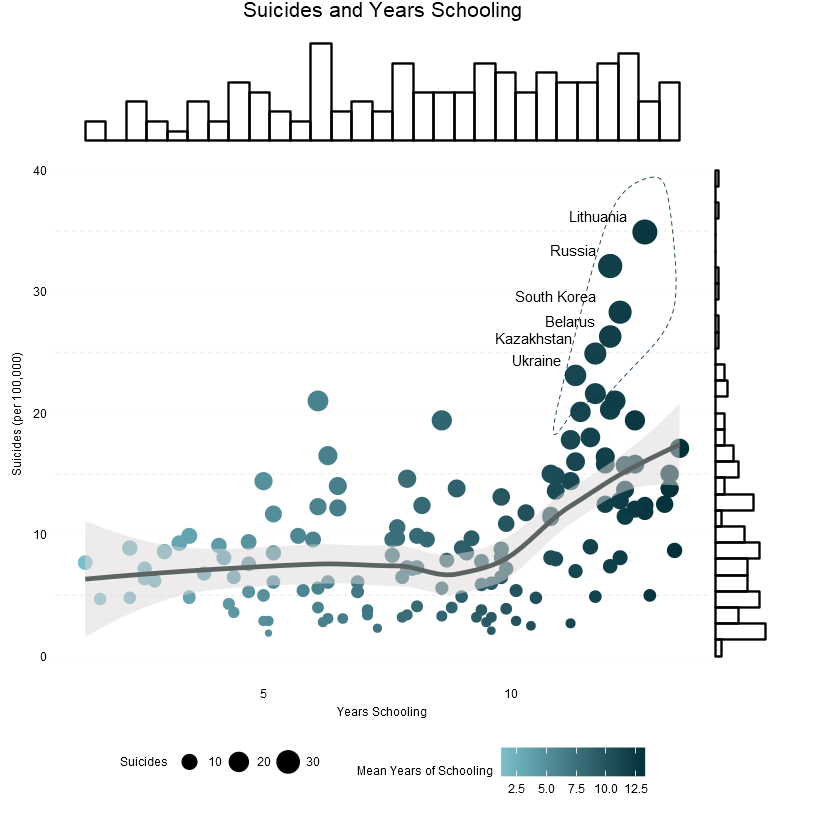

In [17]:
# Save as png
# png("years_schooling.png", width = 8, height = 6, units = 'in', res = 800)

# Extract subset of data to use for encircle
high_suicide_schooling <- happiness_indicators[happiness_indicators$years.schooling > 11 & 
                            happiness_indicators$suicide.per100k > 23, ]

# Scatterplot
years_schooling <- ggplot(happiness_indicators, aes(x=years.schooling, y=suicide.per100k)) + 
    geom_point(aes(col=years.schooling, size=suicide.per100k)) +
    geom_smooth(method="loess", se=T, color="#5c6363", fill="#dcd8d8", alpha=0.5) +

    # xlim(c(2.5, 8)) + 
    ylim(c(0, 40)) +

    geom_encircle(aes(x=years.schooling, y=suicide.per100k),
                  data=high_suicide_schooling,
                  color="#013039",
                  size=0.5,
                  expand=0.1,
                  linetype='dashed') +

    geom_text(aes(label=ifelse(happiness_indicators$years.schooling > 11 & 
                            happiness_indicators$suicide.per100k > 23, 
                               as.character(happiness_indicators$country),'')), 
              hjust=1.3, vjust=-.9, size = 3) +

    labs(title="Suicides and Years Schooling",
         y="Suicides (per 100,000)",
         x="Years Schooling",
         caption="",
         legend="",
         color = "Mean Years of Schooling",
         size = "Suicides") +

    scale_color_gradient(low = "#7ABECB", high = "#013039") +
    theme_minimal() +
    theme(
        plot.title = element_text(size=12,
                                  color="black",
                                  face="plain",
                                  vjust= 0.5,
                                  hjust = 0.5), 
        plot.subtitle  = element_text(size=12,
                                  color="black", 
                                  vjust= 0.5,
                                  hjust = 0.5),
        plot.caption = element_text(hjust=0.5, size=rel(1.2)),
        
        panel.grid.minor.x=element_blank(),
        panel.grid.major.x=element_blank(),
        
        axis.title = element_text(size=7,
                                  color="black",
                                  face="plain",
                                  vjust= 0.5,
                                  hjust = 0.5),
        axis.text = element_text(size=7,
                                  color="black"),
        line = element_line(size=.05,
                            linetype='dashed'),
        legend.title = element_text(size=7,
                                  color="black",
                                  face="plain"),
        legend.text = element_text(size=7,
                                  color="black", 
                                  face="plain"),
        legend.position="bottom"
       )

ggMarginal(years_schooling, type = "histogram", fill="transparent")

# dev.off()

## Suicides vs Alcohol Consumption

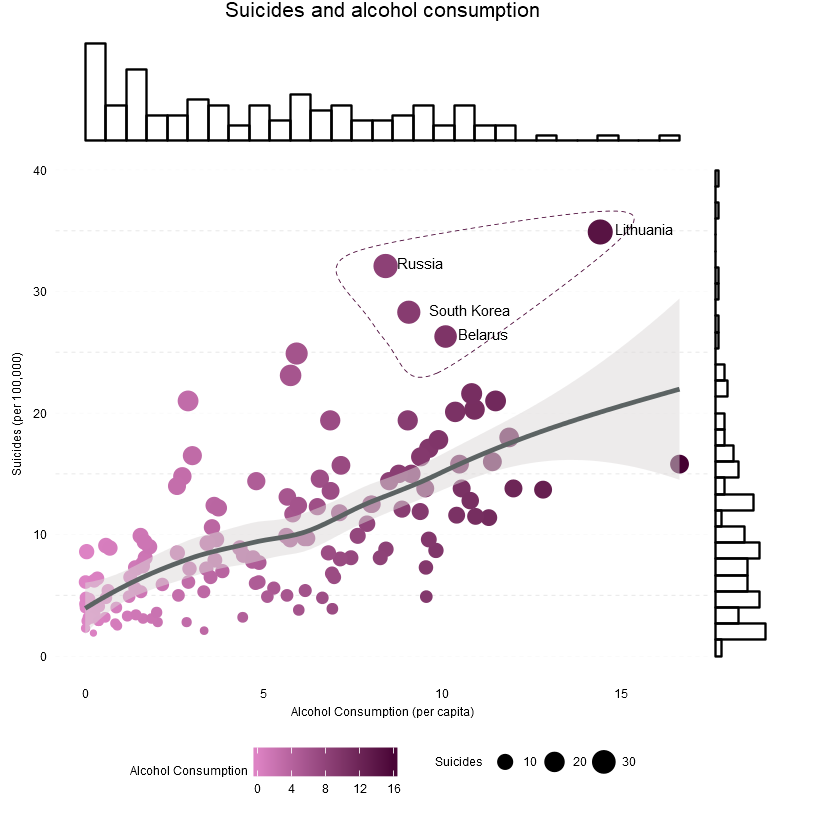

In [18]:
# png("alcohol_consumption.png", width = 8, height = 6, units = 'in', res = 800)

# Extract subset of data to use for encircle
high_suicide_alcohol <- happiness_indicators[happiness_indicators$consumption.percapita > 7 & 
                            happiness_indicators$suicide.per100k > 25, ]

# Scatterplot
alcohol_consumption <- ggplot(happiness_indicators, aes(x=consumption.percapita, y=suicide.per100k)) + 
    geom_point(aes(col=consumption.percapita, size=suicide.per100k)) +
    geom_smooth(method="loess", se=T, color="#5c6363", fill="#dcd8d8", alpha=0.5) +
    
    # xlim(c(2.5, 8)) + 
    ylim(c(0, 40)) +

    geom_encircle(aes(x=round(consumption.percapita,1), y=suicide.per100k),
                  data=high_suicide_alcohol,
                  color="#450032",
                  size=0.5,
                  expand=0.07,
                  linetype='dashed') +
    
    geom_text(aes(label=ifelse(happiness_indicators$consumption.percapita > 7 & 
                            happiness_indicators$suicide.per100k > 25, 
                               as.character(happiness_indicators$country),'')), 
              hjust=-.25, vjust=.3, size = 3) +

    labs(title="Suicides and alcohol consumption",
         y="Suicides (per 100,000)",
         x="Alcohol Consumption (per capita)",
         caption="",
         legend="",
         color = "Alcohol Consumption",
         size = "Suicides") +

    scale_color_gradient(low = "#DD83C4", high = "#450032") +
    theme_minimal() +
    theme(
        plot.title = element_text(size=12,
                                  color="black",
                                  face="plain",
                                  vjust= 0.5,
                                  hjust = 0.5), 
        plot.subtitle  = element_text(size=12,
                                  color="black", 
                                  vjust= 0.5,
                                  hjust = 0.5),
        plot.caption = element_text(hjust=0.5, size=rel(1.2)),
        
        panel.grid.minor.x=element_blank(),
        panel.grid.major.x=element_blank(),
        
        axis.title = element_text(size=7,
                                  color="black",
                                  face="plain",
                                  vjust= 0.5,
                                  hjust = 0.5),
        axis.text = element_text(size=7,
                                  color="black"),
        line = element_line(size=.05,
                            linetype='dashed'),
        legend.title = element_text(size=7,
                                  color="black",
                                  face="plain"),
        legend.text = element_text(size=7,
                                  color="black", 
                                  face="plain"),
        legend.position="bottom"
       )

ggMarginal(alcohol_consumption, type = "histogram", fill="transparent")

# dev.off()

## Suicides vs Alcohol Consumption

After exploring the data set, I decided to look into if living in a happy and wealthy country made people less prone to suicide and other factors that may be related to it. The data indicates that while people who live in a developed country report higher happiness scores in average, suicide rates are slightly higher in these countries. Alcohol consumption particularly shows a strong correlation with suicide.